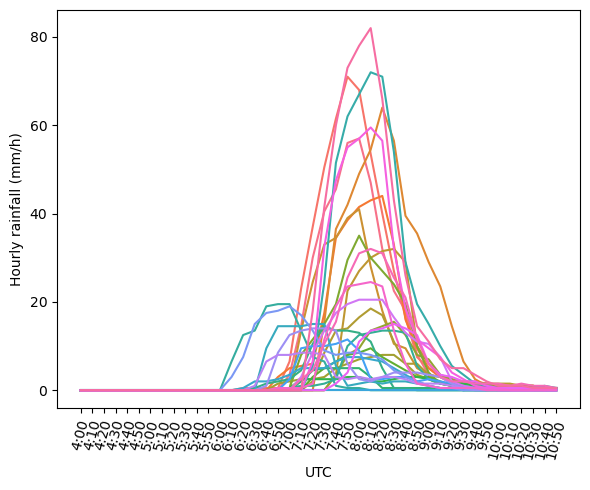

AT1 data of CentPark_00181288 has 25 zero different values.
AT1 data of DOST_00174730 has 14 zero different values.
AT1 data of MM-EFCOS_00173456 has 41 zero different values.
AT1 data of MM-Tapayan_00173458 has 15 zero different values.


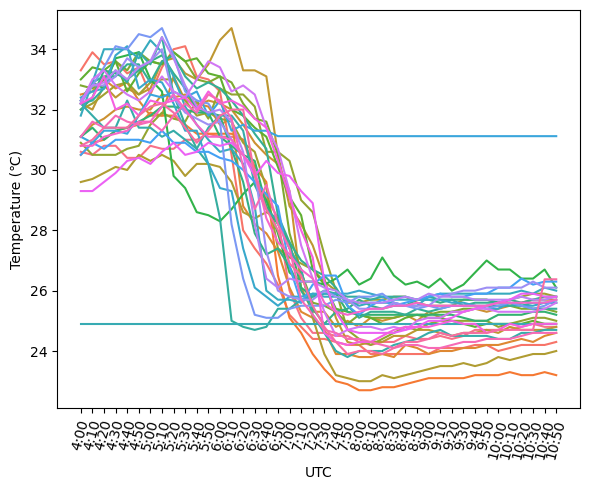

RH1 data of CentPark_00181288 has 23 zero different values.
RH1 data of MM-EFCOS_00173456 has 41 zero different values.


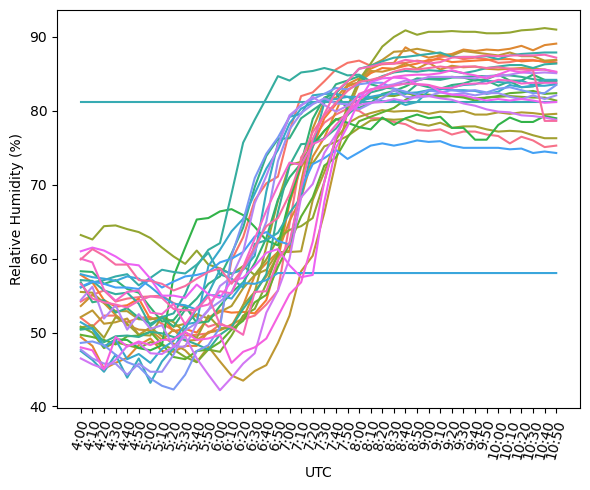

WS1 data of CentPark_00181288 has 26 zero different values.
WS1 data of DOST_00174730 has 14 zero different values.
WS1 data of GH-Subdiv_00181291 has 13 zero different values.
WS1 data of MM-EFCOS_00173456 has 41 zero different values.
WS1 data of MM-SanAndres_00173459 has 14 zero different values.
WS1 data of QC-SciHS_00181271 has 14 zero different values.
WS1 data of RAVE_00181290 has 16 zero different values.
WS1 data of Vlz-Bagbaguin_00174731 has abnormal value.
WS1 data of Vlz-DRRMO_00174734 has abnormal value.
WS1 data of MM-Libertad_00181289 has abnormal value.
WS1 data of Vlz-DRRMO_00174734 has abnormal value.


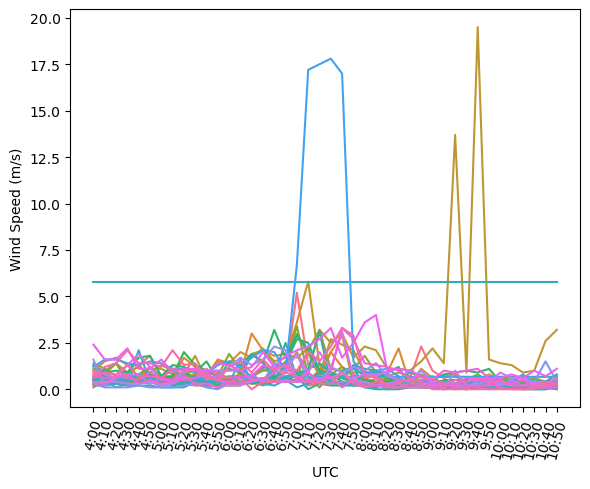

V-Wind data of CentPark_00181288 has 26 zero different values.
V-Wind data of DOST_00174730 has 14 zero different values.
V-Wind data of GH-Subdiv_00181291 has 13 zero different values.
V-Wind data of MM-EFCOS_00173456 has 41 zero different values.
V-Wind data of MM-SanAndres_00173459 has 14 zero different values.
V-Wind data of QC-SciHS_00181271 has 14 zero different values.
V-Wind data of RAVE_00181290 has 16 zero different values.
V-Wind data of Vlz-Bagbaguin_00174731 has abnormal value.
V-Wind data of Vlz-DRRMO_00174734 has abnormal value.
V-Wind data of MM-Libertad_00181289 has abnormal value.
V-Wind data of Vlz-DRRMO_00174734 has abnormal value.


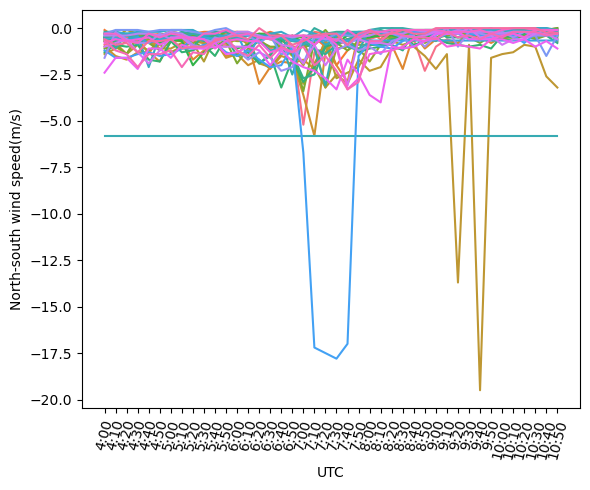

U-Wind data of CentPark_00181288 has 23 zero different values.
U-Wind data of MM-EFCOS_00173456 has 41 zero different values.


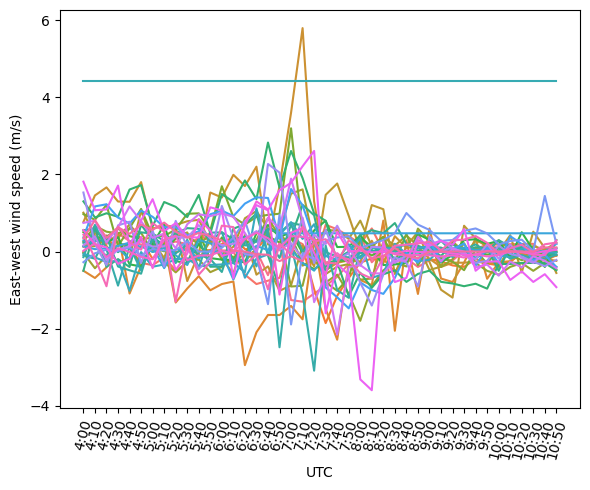

PRS data of CentPark_00181288 has 26 zero different values.
PRS data of LP-Elias_00174724 has 14 zero different values.
PRS data of MM-EFCOS_00173456 has 41 zero different values.


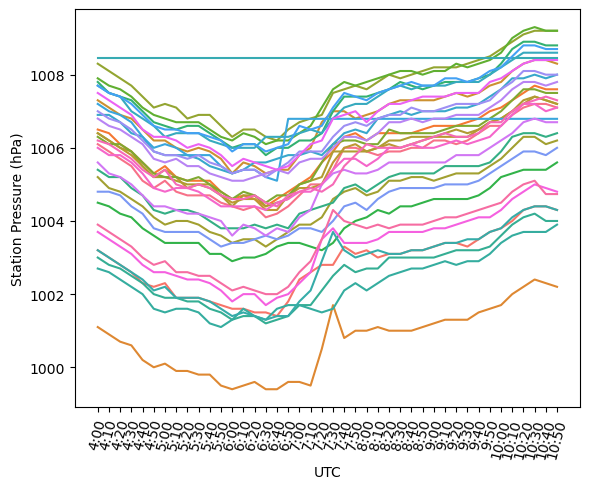

In [1]:
import sys

sys.path.append("../")
from utils import time_series_df, time_series_plot

data_root_dir_path = "../../../data/one_day_data/"
year = "2020"
month = "10"
date = "12"
start_time_h = 4
end_time_h = 10

df = time_series_df(data_root_dir_path, year, month, date, start_time_h, end_time_h)
df.tail()

save_fig_dir = "."
time_series_plot(
    df,
    target_cols=["hour-rain", "AT1", "RH1", "WS1", "WD1", "V-Wind", "U-Wind", "PRS"],
    save_fig_dir=save_fig_dir,
    # exclude_observation_points=["MM-EFCOS_00173456", "CentPark_00181288", "Vlz-DRRMO_00174734", "MM-Libertad_00181289"],
)

In [2]:
df.head()

,hour-rain,AT1,RH1,WS1,WD1,V-Wind,U-Wind,PRS,Time,Station_Name
0,0.0,30.6,54.2,0.9,262.0,-0.9,0.12526,1006.1,4:00,Vlz-Bagbaguin_00174731
1,0.0,33.3,52.0,0.3,271.0,-0.3,-0.00524,1003.2,4:00,NagNayon_00181273
2,0.0,30.5,57.8,0.1,290.0,-0.1,-0.03420,1006.5,4:00,DLSAU_00174722
3,0.0,32.5,49.4,0.6,326.0,-0.6,-0.49742,1001.1,4:00,ASTI_00173457
4,0.0,31.1,53.6,1.0,220.0,-1.0,0.76604,1007.3,4:00,MM-SanAndres_00173459


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

compare_df = pd.DataFrame(columns=["Time", "ParamName", "Value", "Station_Name"])
other_columns = ["Time", "Station_Name"]
param_columns = [col for col in df.columns if col not in other_columns]

scaling_method = "both"

for col in df.columns:
    if col in param_columns:
        param_df = df[[col, "Time", "Station_Name"]].copy(deep=True)

        if scaling_method == "normalize":
            # Normalization
            min_val, max_val = param_df[col].min(), param_df[col].max()
            param_df[col] = (param_df[col] - min_val) / (max_val - min_val)

        elif scaling_method == "standarlize":
            # Standarization
            std, mean = param_df[col].std(), param_df[col].mean()
            param_df[col] = (param_df[col] - mean) / std
        elif scaling_method == "both":
            max_val, min_val = param_df[col].max(), param_df[col].min()
            param_df[col] = (param_df[col] - min_val) / (max_val - min_val)
            std, mean = param_df[col].std(), param_df[col].mean()
            param_df[col] = (param_df[col] - mean) / std
        else:
            raise ValueError(f"Unknown scaling method: {scaling_method}")
        param_df.rename(columns={col: "Value"}, inplace=True)
        param_df["ParamName"] = col
        compare_df = pd.concat([compare_df, param_df], axis=0, ignore_index=True)

In [4]:
compare_df.head()

,Time,ParamName,Value,Station_Name
0,4:00,hour-rain,-0.402993,Vlz-Bagbaguin_00174731
1,4:00,hour-rain,-0.402993,NagNayon_00181273
2,4:00,hour-rain,-0.402993,DLSAU_00174722
3,4:00,hour-rain,-0.402993,ASTI_00173457
4,4:00,hour-rain,-0.402993,MM-SanAndres_00173459


In [5]:
compare_df.describe()

,Value
count,1.041600e+04
mean,5.720047e-15
std,9.996639e-01
min,-1.187609e+01
25%,-4.696599e-01
50%,-1.346726e-01
75%,5.130747e-01
max,1.187609e+01


In [1]:
target_col = ["hour-rain", "AT1", "RH1", "U-Wind", "V-Wind"]
exclude_observation_points=["MM-EFCOS_00173456", "CentPark_00181288", "Vlz-DRRMO_00174734", "MM-Libertad_00181289"]
fig, ax = plt.subplots(figsize=(10, 7))

# for station_name, grouped_df in compare_df.groupby(by=["Station_Name"]):
#     if station_name not in exclude_observation_points:
#         sns.lineplot(data=grouped_df, x="Time", y="Value", hue="ParamName", hue_order=target_col, ax=ax)

compare_df = compare_df.loc[~compare_df["Station_Name"].isin([exclude_observation_points])]
sns.lineplot(data=compare_df, x="Time", y="Value", hue="ParamName", hue_order=target_col, ax=ax)
ax.legend(["Hourly rainfall", "Temperature", "Relative Humidity", "U-Wind", "V-Wind"])
plt.xticks(rotation=75)
plt.show()
plt.close()

NameError: name 'plt' is not defined

In [7]:
df

,hour-rain,AT1,RH1,WS1,WD1,V-Wind,U-Wind,PRS,Time,Station_Name
0,0.0,30.60000,54.200000,0.90000,262.000000,-0.90000,0.12526,1006.100000,4:00,Vlz-Bagbaguin_00174731
1,0.0,33.30000,52.000000,0.30000,271.000000,-0.30000,-0.00524,1003.200000,4:00,NagNayon_00181273
2,0.0,30.50000,57.800000,0.10000,290.000000,-0.10000,-0.03420,1006.500000,4:00,DLSAU_00174722
3,0.0,32.50000,49.400000,0.60000,326.000000,-0.60000,-0.49742,1001.100000,4:00,ASTI_00173457
4,0.0,31.10000,53.600000,1.00000,220.000000,-1.00000,0.76604,1007.300000,4:00,MM-SanAndres_00173459
...,...,...,...,...,...,...,...,...,...,...
1297,0.0,25.80000,81.200000,1.10000,33.000000,-1.10000,-0.92254,1008.400000,10:50,MM-Balut_00174728
1298,0.5,24.90000,85.300000,0.10000,116.000000,-0.10000,0.04384,1004.800000,10:50,Xavier-Sch_00181285
1299,0.0,25.70000,83.800000,0.30000,197.000000,-0.30000,0.28689,1007.100000,10:50,DOST_00174730
1300,0.5,24.60000,87.200000,0.30000,141.000000,-0.30000,0.23314,1007.300000,10:50,Vlz-Punturin_00174725
